In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn import datasets
import matplotlib.pyplot as plt
from time import time

# SVRF

In [6]:
def CalculatePartialGradient(w, i):
    grad = np.array([e[i] for l in range(h)])
    exponents = np.exp(e[i].dot(w.transpose()))
    exponents /= exponents.sum()
    for l in range(h):
        grad[l] *= exponents[l]
    grad[y[i]] -= e[i]
    return grad
    
def CalculateGradient(w):
    grads_sum = np.full((h, m), 0.0)
    for i in range(n):
        grads_sum += CalculatePartialGradient(w, i)
    return grads_sum / n
    
def DoLinOpt(matrix):
    u, s, vt = svds(matrix, 1)
    return -tau * u.dot(vt)

def CalculateVarRedSG(w, full_grad, w_0):
    rand_ind = np.random.randint(0, n)
    return CalculatePartialGradient(w, rand_ind) -\
            (CalculatePartialGradient(w_0, rand_ind) - full_grad)

def GetGamma(k):
    return 0.1 / (k + 2)

def GetM(k):
    return 50

def GetN(t):
    return 25

def CalcLoss(w):
    loss_sum = 0
    for i in range(n):
        loss_sum += np.log(np.exp(e[i].dot(w.transpose())).sum())
        loss_sum -= e[i].dot(w[y[i]])
    return loss_sum / n 

def DoSVRF(T, start_time, times):
    w = []
    x_init = np.full((h, m), 0.0)
    full_grad = CalculateGradient(x_init)
    w += [DoLinOpt(full_grad)]
    for t in range(T):
        x = []
        x += [w[-1]]
        full_grad = CalculateGradient(x[0])
        for k in range(GetN(t)):
            if k != 0:
                sum_grads = np.full((h, m), 0.0)
                for i in range(GetM(k)):
                    sum_grads += CalculateVarRedSG(x[-1], full_grad, x[0])
                curr_grad = sum_grads / GetM(k)
            else:
                curr_grad = full_grad
            
            v = DoLinOpt(curr_grad)
            gamma = GetGamma(k)
            x += [(1 - gamma) * x[-1] + gamma * v]
            w += [x[-1]]
            times.append(round(time() - start_time, 2))
    return w, times

In [7]:
a, b = datasets.load_svmlight_file('usps')

In [8]:
e = a.toarray()
y = np.array(b, int) - 1
tau = 50
n, m = e.shape
h = len(set(y))

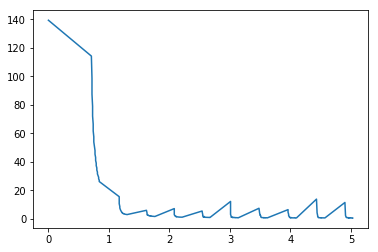

In [9]:
times = [0]
start_time = time()
seq, times = DoSVRF(10, start_time, times)
vals = [CalcLoss(w) for w in seq]
plt.plot(times, vals)

In [10]:
np.save('losses/losses_SVRF', np.array(vals))
np.save('losses/times_SVRF', times)

# STORC

In [11]:
tau = 50
n, m = e.shape
h = len(set(y))

def CalculatePartialGradient(w, i):
    grad = np.array([e[i] for l in range(h)])
    exponents = np.exp(e[i].dot(w.transpose()))
    exponents /= exponents.sum()
    for l in range(h):
        grad[l] *= exponents[l]
    grad[y[i]] -= e[i]
    return grad
    

def CalculateGradient(w):
    grads_sum = np.full((h, m), 0.0)
    for i in range(n):
        grads_sum += CalculatePartialGradient(w, i)
    return grads_sum / n
    
def DoLinOpt(matrix):
    u, s, vt = svds(matrix, 1)
    return -tau * u.dot(vt)

def CalculateVarRedSG(w, full_grad, w_0):
    rand_ind = np.random.randint(0, n)
    return CalculatePartialGradient(w, rand_ind) -\
            (CalculatePartialGradient(w_0, rand_ind) - full_grad)

def CalcLoss(w):
    loss_sum = 0
    for i in range(n):
        loss_sum += np.log(np.exp(e[i].dot(w.transpose())).sum())
        loss_sum -= e[i].dot(w[y[i]])
    return loss_sum / n 

def GetGamma(k):
    return 0.5 / (k + 2)

def GetM(k):
    return 50

def GetN(t):
    return 50

def GetEta(k):
    return 30 / (50 * (k + 1))

def GetBeta(k):
    return 3 / (k + 1)

def DoSTORC(T, start_time, times):
    w = []
    x_init = np.full((h, m), 0.0)
    full_grad = CalculateGradient(x_init)
    w += [DoLinOpt(full_grad)]
    for t in range(T):
        x = []
        y = []
        x += [w[-1]]
        y += [w[-1]]
        full_grad = CalculateGradient(y[0])
        for k in range(GetN(t)):
            gamma = GetGamma(k)
            if k != 0:
                z = (1 - gamma) * y[-1] + gamma * x[-1]
                sum_grads = np.full((h, m), 0.0)
                M = GetM(k)
                for i in range(M):
                    sum_grads += CalculateVarRedSG(z, full_grad, y[0])
                curr_grad = sum_grads / M
            else:
                z = y[-1]
                curr_grad = full_grad
            
            beta = GetBeta(k)
            eta = GetEta(k)
            xi = x[-1]
            count = 2
            while 1:
                additional_grad = beta * (xi - x[-1]) + curr_grad
                zeta = DoLinOpt(additional_grad)
                if (xi - zeta).dot(additional_grad.transpose()).trace() <= eta:
                    break
                step = 1 / count
                xi = (1 - step) * xi + step * zeta
                count += 1
            x += [xi]
            
            y += [(1 - gamma) * y[-1] + gamma * x[-1]]
            w += [y[-1]]
            times.append(round(time()-start_time, 2))
    return w, times

In [12]:
times = [0]
start_time = time()

seq, times = DoSTORC(2, start_time, times)
vals = [CalcLoss(w) for w in seq]

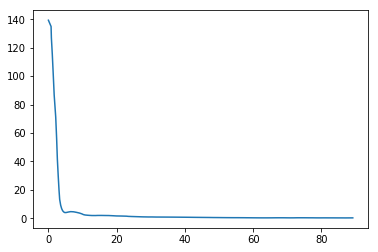

In [13]:
plt.plot(times, vals)

In [14]:
np.save('losses/losses_STORC', np.array(vals))
np.save('losses/times_STORC', times)